In [140]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

c:\Users\victo\anaconda3\envs\montecarlo\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [141]:
def successor(X, s, r, delta, m, T):
    h = T/(m-1)
    z = np.random.normal()
    return X * np.exp((r - delta - 0.5 * s**2) * h + s * np.sqrt(h) * z)

def black_scholes(X0, s, r, delta, m, T):
    X = [X0]
    for i in range(m):
        X.append(successor(X[-1], s, r, delta, m, T))
    return X

def put_func(a, K):
    """
    Payoff function for a Bermudan put option
    """
    return np.maximum(K - a, 0)

def call_func(a, K):
    """
    Payoff function for a Bermudan call option
    """
    return np.maximum(a - K, 0)

def high_estimator(payoff_func, current, next, K):
    return max(payoff_func(current, K), np.mean(next))

def low_estimator(payoff_func, current, next, K):
    b = len(next)
    v_ = np.zeros(b)
    for k in range(b):
        new = np.concatenate([next[:k], next[k:]])
        if np.mean(new) <= payoff_func(current, K):
            v_[k] = payoff_func(current, K)
        else:
            v_[k] = next[k]
    return np.mean(v_)


In [142]:
def rtree(X0, m, b, s, r, delta, K, T, payoff_func):
    w = np.zeros(m).astype(int)     # to know at which branch we are
    v = np.zeros((b, m))   # to store the value of the option and high estimator at each node
    V = np.zeros((b, m))   # to store the value of the option and low estimator at each node

    v[0, 0] = X0
    V[0, 0] = X0
    
    w[0] = 0
    for j in range(1, m):
        v[0, j] = successor(v[0, j-1], s, r, delta, m, T)
        V[0, j] = successor(V[0, j-1], s, r, delta, m, T)
        w[j] = 0
    j = m - 1
    while j >= 0:
        if j == m-1 and w[j] < b-1:
            v[w[j], j] = payoff_func(v[w[j], j], K)
            V[w[j], j] = payoff_func(V[w[j], j], K)
            v[w[j]+1, j] = successor(v[w[j-1], j-1], s, r, delta, m, T)
            V[w[j]+1, j] = successor(V[w[j-1], j-1], s, r, delta, m, T)
            w[j] += 1
        elif j == m-1 and w[j] == b-1:
            v[w[j], j] = payoff_func(v[w[j], j], K)
            V[w[j], j] = payoff_func(V[w[j], j], K)
            w[j] = 0
            j -= 1
        elif j < m-1 and w[j] < b-1:
            V[w[j], j] = high_estimator(payoff_func, V[w[j], j], V[:, j+1], K)
            v[w[j], j] = low_estimator(payoff_func, v[w[j], j], v[:, j+1], K)
            if j > 0:
                w[j] += 1
                v[w[j], j] = successor(v[w[j-1], j-1], s, r, delta, m, T)
                V[w[j], j] = successor(V[w[j-1], j-1], s, r, delta, m, T)
                for i in range(j+1, m):
                    v[0, i] = successor(v[w[j], i-1], s, r, delta, m, T)
                    V[0, i] = successor(V[w[j], i-1], s, r, delta, m, T)
                j = m - 1
            else:
                break
        elif j < m-1 and w[j] == b-1:
            v[w[j], j] = low_estimator(payoff_func, v[w[j], j], v[:, j+1], K)
            V[w[j], j] = high_estimator(payoff_func, V[w[j], j], V[:, j+1], K)
            w[j] = 0
            j -= 1
    return v[0, 0], V[0, 0]

In [147]:
def monte_carlo(n, X0, m, b, s, r, delta, K, T, payoff_func):
    eff_low = []
    eff_high = []
    for _ in tqdm(range(n)):
        eff_low.append(rtree(X0, m, b, s, r, delta, K, T, payoff_func)[0])
        eff_high.append(rtree(X0, m, b, s, r, delta, K, T, payoff_func)[1])
    return eff_low, eff_high

In [167]:
n = 100
X0 = 100
m = 4
b = 30
s = 0.2
r = 0.05
delta = 0.1
K = 100
T = 1
eff_low, eff_high = monte_carlo(n, X0, m, b, s, r, delta, K, T, call_func)

100%|██████████| 100/100 [07:49<00:00,  4.69s/it]


In [168]:
parameters = [n, X0, m, b, s, r, delta, K, T]
np.save('parametersb30.npy', parameters)
np.save('runb30.npy', [eff_low, eff_high])

In [169]:
std_v = np.std(eff_low)
std_V = np.std(eff_high)
mean_v = np.mean(eff_low)
mean_V = np.mean(eff_high)
low_est = mean_v - 1.96 * std_v / np.sqrt(n)
high_est = mean_V + 1.96 * std_V / np.sqrt(n)
print('90% confidence interval for the low estimator: [', low_est, high_est,']')
print('Std for the low estimator:', std_v)
print('Std for the high estimator:', std_V)
print('Point estimate:', np.mean([low_est, high_est]))

90% confidence interval for the low estimator: [ 5.885549637858789 6.222091070952009 ]
Std for the low estimator: 1.2146053183286194
Std for the high estimator: 1.039210413113162
Point estimate: 6.053820354405399


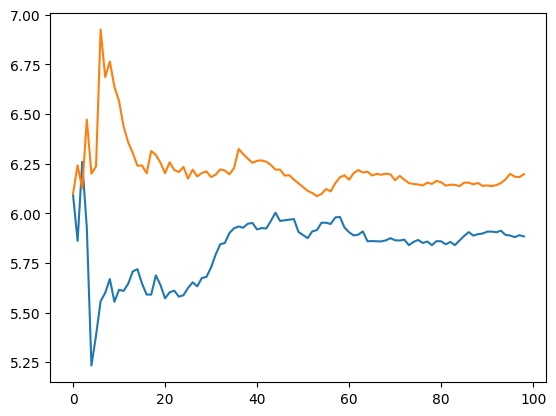

In [170]:
plt.plot([np.mean(eff_low[:i]) - 1.96*np.std(eff_low[:i])/np.sqrt(i) for i in range(1, n)])
plt.plot([np.mean(eff_high[:i]) + 1.96*np.std(eff_high[:i])/np.sqrt(i) for i in range(1, n)])